In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf

import zipfile
from PIL import Image
import sklearn.metrics
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data Preparation

In [3]:
! kaggle datasets download -d shylesh101/tomato-leaf-disease

Dataset URL: https://www.kaggle.com/datasets/shylesh101/tomato-leaf-disease
License(s): unknown




  0%|          | 0.00/370M [00:00<?, ?B/s]
  0%|          | 1.00M/370M [00:01<08:05, 798kB/s]
  1%|          | 2.00M/370M [00:01<04:40, 1.38MB/s]
  1%|          | 3.00M/370M [00:02<03:46, 1.70MB/s]
  1%|          | 4.00M/370M [00:02<03:09, 2.03MB/s]
  1%|▏         | 5.00M/370M [00:02<02:53, 2.20MB/s]
  2%|▏         | 6.00M/370M [00:03<02:55, 2.18MB/s]
  2%|▏         | 7.00M/370M [00:03<02:50, 2.23MB/s]
  2%|▏         | 8.00M/370M [00:04<03:01, 2.09MB/s]
  2%|▏         | 9.00M/370M [00:04<03:00, 2.11MB/s]
  3%|▎         | 10.0M/370M [00:05<02:56, 2.14MB/s]
  3%|▎         | 11.0M/370M [00:05<02:42, 2.32MB/s]
  3%|▎         | 12.0M/370M [00:06<02:31, 2.48MB/s]
  4%|▎         | 13.0M/370M [00:06<02:24, 2.60MB/s]
  4%|▍         | 14.0M/370M [00:06<02:25, 2.56MB/s]
  4%|▍         | 15.0M/370M [00:07<02:29, 2.50MB/s]
  4%|▍         | 16.0M/370M [00:07<02:31, 2.45MB/s]
  5%|▍         | 17.0M/370M [00:08<02:34, 2.40MB/s]
  5%|▍         | 18.0M/370M [00:08<02:32, 2.43MB/s]
  5%|▌         | 19.0

In [2]:
# Tentukan path ke file zip dataset
zip_path = 'tomato-leaf-disease.zip'

# Tempat direktori untuk mengekstrak dataset
extract_path = 'D:/Skripsi/Code/'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

['.git', 'chili-plant-disease.zip', 'chilli_model.ipynb', 'Dataset', 'Dataset_main', 'Dataset_tomato', 'plant-disease-classification-merged-dataset.zip', 'tomato-leaf-disease.zip', 'tomato_dataset', 'tomato_model.h5', 'tomato_model.ipynb']


In [5]:
# Path ke direktori dataset chili
path_dataset = "D:/Skripsi/Code/tomato_dataset/"
train_dir = path_dataset + "/train"
val_dir = path_dataset + "/valid"
test_dir = path_dataset + "/test"

# Spliting

In [6]:
# Define the image data generator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (224, 224),
    batch_size=32,
    class_mode='categorical')

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

# Test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Modelling

In [11]:
# Load the MobileNetV2 model with pre-trained ImageNet weights, excluding the top layers
mobilenetv2_base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in mobilenetv2_base_model.layers:
    layer.trainable = False

mobilenetv2 = models.Sequential()
mobilenetv2.add(mobilenetv2_base_model)
mobilenetv2.add(layers.GlobalAveragePooling2D())
mobilenetv2.add(layers.Dense(10, activation='softmax'))

mobilenetv2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Kompilasi model
mobilenetv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
mobilenetv2_history = mobilenetv2.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator)

Epoch 1/30


c:\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 195s 333ms/step - accuracy: 0.5814 - loss: 1.2653 - val_accuracy: 0.8087 - val_loss: 0.5838
Epoch 2/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 194s 337ms/step - accuracy: 0.8305 - loss: 0.5308 - val_accuracy: 0.8393 - val_loss: 0.4957
Epoch 3/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 193s 334ms/step - accuracy: 0.8496 - loss: 0.4546 - val_accuracy: 0.8493 - val_loss: 0.4449
Epoch 4/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 206s 357ms/step - accuracy: 0.8660 - loss: 0.4135 - val_accuracy: 0.8628 - val_loss: 0.4085
Epoch 5/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 206s 356ms/step - accuracy: 0.8678 - loss: 0.3860 - val_accuracy: 0.8639 - val_loss: 0.4015
Epoch 6/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 194s 336ms/step - accuracy: 0.8744 - loss: 0.3707 - val_accuracy: 0.8726 - val_loss: 0.3744
Epoch 7/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 193s 335ms/step - accuracy: 0.8812 - loss: 0.3500 - val_accuracy: 0.8735 - val_loss: 0.3707
Epoch 8/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 205s 355ms/step - accuracy: 0.8835 - loss: 0.33

# Testing

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
image_size = (224, 224)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 50 images belonging to 10 classes.


In [14]:
# Show the model architecture
mobilenetv2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,416 (8.76 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 25,622 (100.09 KB)

In [15]:
# Evaluate the model
evaluation_results = mobilenetv2.evaluate(test_generator)

# Print evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7967 - loss: 0.5375
Test Loss: 0.47747623920440674
Test Accuracy: 0.8199999928474426


In [17]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 4585 images belonging to 10 classes.


In [25]:
# Evaluate the model
evaluation_results = mobilenetv2.evaluate(validation_generator)

# Print evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.8624 - loss: 0.4290
Test Loss: 0.4035657048225403
Test Accuracy: 0.8693565726280212


In [21]:
# Assuming your model object is called 'model'
mobilenetv2.save('tomato_model.h5')

In [15]:
model = tf.keras.models.load_model('tomato_model.h5')

In [55]:
evaluation_results = model.evaluate(test_generator)

# Print evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7967 - loss: 0.5375
Test Loss: 0.47747623920440674
Test Accuracy: 0.8199999928474426


# Manual Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


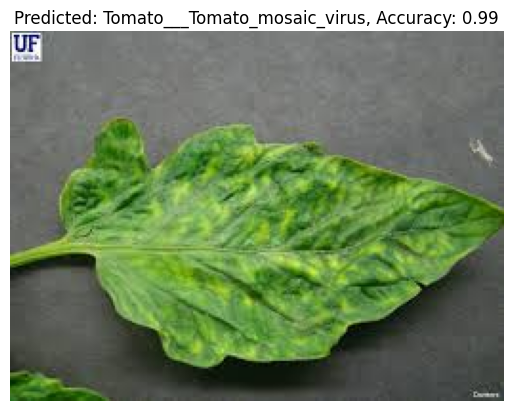

In [16]:
labels_dir = "D:/Skripsi/Code/tomato_dataset/train"
# Path to your new image
img_path = 'tomat9.jpg'

# Load the image and convert it to an array
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

# Expand dimensions to create a batch of size 1
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image array
img_array = preprocess_input(img_array)

# Make predictions using the loaded model
predictions = model.predict(img_array)

# Get the index of the class with the highest probability
predicted_class_idx = np.argmax(predictions, axis=1)[0]

# Get the list of class labels from the directory names
class_labels = sorted(os.listdir(labels_dir))

# Get the class label for the predicted class
predicted_class_label = class_labels[predicted_class_idx]

# Display the image
plt.imshow(load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}, Accuracy: {np.max(predictions):.2f}")
plt.axis('off')
plt.show()

